In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
json_file_path = '/content/drive/MyDrive/Colab Notebooks/train.json'
import json
with open(json_file_path, 'r') as file:
    train_data = json.load(file)


In [3]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained Clinical BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(clinical_bert_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [4]:
label_mapping = {
    'Entailment': 1,
    'Contradiction': 0
}

In [5]:
import json
import os
import re
import random
from torch.utils.data import DataLoader
import nltk
from nltk.corpus import wordnet
import random
import medspacy
from medspacy.ner import TargetRule

nltk.download('wordnet')

ctr_json_folder = '/content/drive/MyDrive/Colab Notebooks/CT json' 

nlp = medspacy.load()

def medical_synonym_replacement(sentence, n=2):
    doc = nlp(sentence)
    new_words = sentence.split()
    random_word_list = [ent.text for ent in doc.ents if ent._.umls_ents]
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = random_word._.umls_ents[0].concept.synonyms
        if synonyms and len(synonyms) > 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    sentence = ' '.join(new_words)
    return sentence


def preprocess_data(train_data):
    preprocessed_data = []
    augmented_data = []  
    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id'] + '.json'
        ctr_1f = os.path.join(ctr_json_folder, ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id'] + '.json'
            ctr_2f = os.path.join(ctr_json_folder, ctr_2)
            secondaryid_exists = True

        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = "Compare CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']])  + "[SEP]"+ "and CTR 2" + " [SEP] ".join(
                    ctr_b[data["Section_id"]]) + "to determine if the given statement" + " [SEP] " + data["Statement"] +"[SEP]"+"is true"
            else:
                ctr = "Analyze CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) + "[SEP]"+" To determine if the given Statement" + " [SEP] " + data["Statement"]+"[SEP]"+"is true"
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]', '', ctr)

        augmented_statement = medical_synonym_replacement(ctr)
        augmented_inputs = tokenizer(augmented_statement, return_tensors='pt', max_length=512, padding='max_length', truncation=True)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])

        preprocessed_data.append((inputs, labels))
        preprocessed_data.append((augmented_inputs, labels))


    return preprocessed_data


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:


preprocessed_data = preprocess_data(train_data)



In [10]:
import pickle
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

In [11]:
print(len(preprocessed_data))

3400


In [12]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/dev.json', 'r') as file:
    dev_data = json.load(file)


dev_preprocessed_data = preprocess_data(dev_data)

In [13]:
import pickle
with open('dev_preprocessed_data.pkl', 'wb') as f:
    pickle.dump(dev_preprocessed_data, f)

In [14]:
import numpy as np


data = preprocessed_data + dev_preprocessed_data
data = list(data)
val_size = int(len(data) * 0.15)

np.random.shuffle(data)

val_data = data[:val_size]
train_data = data[val_size:]


In [15]:
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [16]:
for param in list(clinical_bert_model.parameters())[:-3]:
    param.requires_grad = False

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
import torch.nn.functional as F


class CustomClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(768, num_classes)  

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  

        logits = self.classifier(pooled_output)
        return logits

num_classes = 2  
model = CustomClassifier(clinical_bert_model, num_classes)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
from sklearn.metrics import accuracy_score


device = torch.device('cuda')

model.to(device)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
NUM_EPOCHS=20
best_val_acc = float('-inf')


for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    train_predicted = []
    train_labels = []
    for batch in train_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']

        labels = batch[1]
        labels.to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask).to(device)
        loss_fn = nn.CrossEntropyLoss()
        logits = logits.squeeze(1)
        labels = labels.squeeze(1)

        labels = labels.to(logits.device)

        loss = F.binary_cross_entropy_with_logits(logits[:, 1], labels.float())

        loss.backward()

        total_train_loss += loss.item()

        optimizer.step()
        _, predicted = torch.max(logits, 1)
        train_predicted.extend(predicted.tolist())
        train_labels.extend(labels.tolist())
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()


    train_loss = total_train_loss / len(train_loader)
    train_acc_score = accuracy_score(train_labels, train_predicted)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc_score)


    # Validation
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_predicted = []
    val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch[0]['input_ids']
            attention_mask = batch[0]['attention_mask']

            labels = batch[1]
            labels.to(device)
            input_ids = input_ids.squeeze(1).to(device)
            attention_mask = attention_mask.squeeze(1).to(device)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask).to(device)
            loss_fn = nn.CrossEntropyLoss()
            logits = logits.squeeze(1)
            labels = labels.squeeze(1)

            labels = labels.to(logits.device)

            loss = F.binary_cross_entropy_with_logits(logits[:, 1], labels.float())

            total_val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            val_predicted.extend(predicted.tolist())
            val_labels.extend(labels.tolist())
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = total_val_loss / len(val_loader)
    val_acc_score = accuracy_score(val_labels, val_predicted)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc_score)

    if val_acc_score > best_val_acc:
        best_val_acc = val_acc_score
        torch.save(model.state_dict(), 'NLP_milestone3_snow_model_state.pth')

    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc_score:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc_score:.4f}')

Epoch 1/20, Train Loss: 0.7000, Train Accuracy: 0.4988, Val Loss: 0.6962, Val Accuracy: 0.4772
Epoch 2/20, Train Loss: 0.6947, Train Accuracy: 0.4988, Val Loss: 0.6995, Val Accuracy: 0.4789
Epoch 3/20, Train Loss: 0.6946, Train Accuracy: 0.5031, Val Loss: 0.6998, Val Accuracy: 0.4789
Epoch 4/20, Train Loss: 0.6940, Train Accuracy: 0.5040, Val Loss: 0.7008, Val Accuracy: 0.4789
Epoch 5/20, Train Loss: 0.6929, Train Accuracy: 0.5093, Val Loss: 0.7037, Val Accuracy: 0.4719
Epoch 6/20, Train Loss: 0.6930, Train Accuracy: 0.5108, Val Loss: 0.7028, Val Accuracy: 0.4719
Epoch 7/20, Train Loss: 0.6934, Train Accuracy: 0.5139, Val Loss: 0.7042, Val Accuracy: 0.4754
Epoch 8/20, Train Loss: 0.6929, Train Accuracy: 0.5155, Val Loss: 0.7025, Val Accuracy: 0.4754
Epoch 9/20, Train Loss: 0.6926, Train Accuracy: 0.5121, Val Loss: 0.7045, Val Accuracy: 0.4649
Epoch 10/20, Train Loss: 0.6930, Train Accuracy: 0.5118, Val Loss: 0.7033, Val Accuracy: 0.4754
Epoch 11/20, Train Loss: 0.6918, Train Accuracy: 

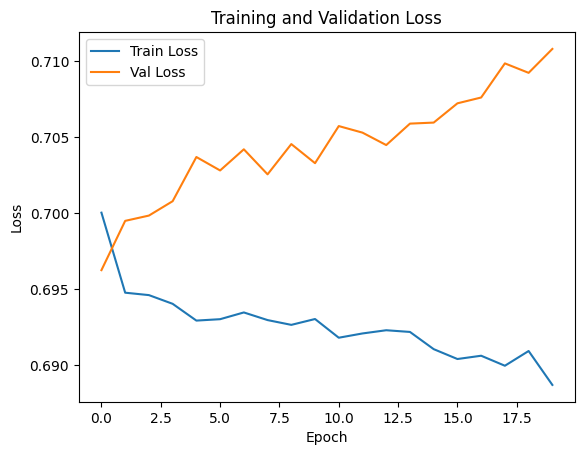

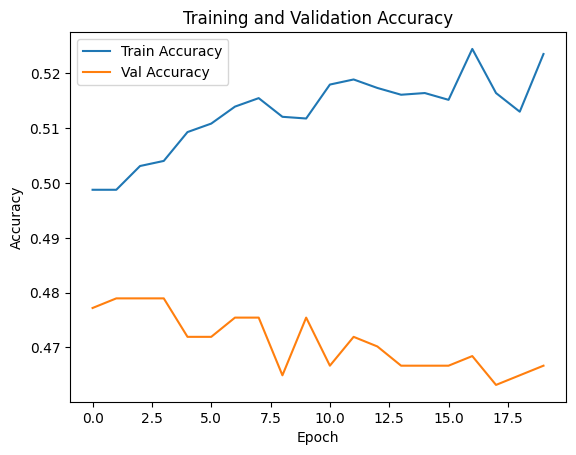

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot( val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot( train_accuracies, label='Train Accuracy')
plt.plot( val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.4667
Precision: 0.4453, Recall: 0.4667, F1 Score: 0.3544


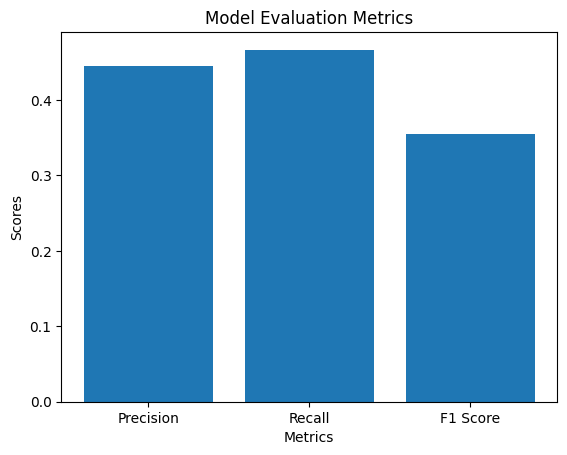

In [23]:

plt.bar(labels, scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.show()




In [24]:
# model.load_state_dict(torch.load('milestone2_NLP_model_state.pth'))

model.eval()

CustomClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [26]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/gold_practice_test.json', 'r') as file:
    gold_practice_test = json.load(file)



In [29]:
def preprocess_test_data(train_data):
    preprocessed_data = []

    for data_id, data in train_data.items():
        ctr_1 = data['Primary_id'] + '.json'
        ctr_1f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_1)
        secondaryid_exists = False
        if 'Secondary_id' in data:
            ctr_2 = data['Secondary_id'] + '.json'
            ctr_2f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_2)
            secondaryid_exists = True

        with open(ctr_1f, 'r') as file:
            ctr_a = json.load(file)
            if secondaryid_exists:
                with open(ctr_2f, 'r') as file:
                    ctr_b = json.load(file)
                ctr = "CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) +"[SEP]"+ "CTR 2" + " [SEP] ".join(
                    ctr_b[data["Section_id"]]) + "[SEP]"+"Data" + " [SEP] " + data["Statement"]
            else:
                ctr = "CTR 1" + " [SEP] ".join(ctr_a[data['Section_id']]) + "[SEP]"+"Data" + " [SEP] " + data["Statement"]
        ctr = ctr.lower()
        url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

        ctr = re.sub(url_ptrn, '', ctr)
        ctr = re.sub(r'[^\w\s]', '', ctr)

        inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)
        labels = torch.tensor([label_mapping[data['Label']]])

        preprocessed_data.append((inputs, labels))


    return preprocessed_data


In [30]:
gold_test = preprocess_test_data(gold_practice_test)

In [31]:
from torch.utils.data import DataLoader

batch_size = 64
gold_test_loader = DataLoader(gold_test, batch_size=batch_size)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in gold_test_loader:
        input_ids = batch[0]['input_ids']
        attention_mask = batch[0]['attention_mask']
        labels = batch[1].to(device)
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


In [33]:
import numpy as np

true_labels = np.array(true_labels)
predictions = np.array(predictions)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


Accuracy: 0.3987
Precision: 0.5609, Recall: 0.3987, F1 Score: 0.3457


In [34]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
faithfulness = sum(abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [35]:
print(faithfulness)

[0.60130719]


In [36]:
if len(true_labels) != len(predictions):
        raise ValueError("The lists of predictions must have the same length.")
consistency = sum(1-abs(o - c) for o, c in zip(true_labels, predictions)) / len(true_labels)

In [37]:
print(consistency)

[0.39869281]


In [39]:

import json
with open('/content/drive/MyDrive/Colab Notebooks/test.json', 'r') as file:
    test_data = json.load(file)


In [41]:
import json

test_preprocessed_data = []
data_ids = [] 

for data_id, data in test_data.items():
    ctr_1 = data['Primary_id'] + '.json'
    ctr_1f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_1)
    secondaryid_exists = False
    if 'Secondary_id' in data:
        ctr_2 = data['Secondary_id'] + '.json'
        ctr_2f = os.path.join('/content/drive/MyDrive/Colab Notebooks/CT json', ctr_2)
        secondaryid_exists = True

    with open(ctr_1f, 'r') as file:
        ctr_a = json.load(file)
        if secondaryid_exists:
            with open(ctr_2f, 'r') as file:
                ctr_b = json.load(file)
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + \
                  " ".join(ctr_b[data["Section_id"]]) + " [SEP] " + data["Statement"]
        else:
            ctr = " ".join(ctr_a[data['Section_id']]) + " [SEP] " + data["Statement"]

    ctr = ctr.lower()
    url_ptrn = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    ctr = re.sub(url_ptrn, '', ctr)
    ctr = re.sub(r'[^\w\s]', '', ctr)

    inputs = tokenizer(ctr, return_tensors='pt', max_length=512, padding='max_length', truncation=True)

    test_preprocessed_data.append(inputs)
    data_ids.append(data_id)  


In [42]:
from torch.utils.data import DataLoader

batch_size = 64
test_loader = DataLoader(test_preprocessed_data, batch_size=batch_size)

In [44]:

model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader: 
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        input_ids = input_ids.squeeze(1).to(device)
        attention_mask = attention_mask.squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())


In [45]:

predictions_dict = {}
for data_id, prediction in zip(data_ids, predictions):
    prediction_label = "Contradiction" if prediction == 0 else "Entailment"
    predictions_dict[data_id] = {"Prediction": prediction_label}

output_file_path = "predictions.json"
with open(output_file_path, "w") as f:
    json.dump(predictions_dict, f, indent=4)

print("Predictions saved to:", output_file_path)


Predictions saved to: predictions.json
